# Data loading - check to correctly understand data / label format

- load data from confocal boundary example dataset
- watch how data changes formats / shapes throughout the training pipeline.

- details:  
 - pytorch always uses the pattern: raw data -> Dataset -> DataLoader, and the DataLoader is in turn fed to the model.
 - when the Dataset object is being created, the original raw volumes are (somehow?) randomly subsampled into many volume patches, on which the model is ultimately trained.
 

In [88]:
import os

import pandas as pd
import matplotlib.pyplot as plt

import pytorch3dunet
import pytorch3dunet.unet3d as u3  # !
from pytorch3dunet import predict
from pytorch3dunet import train

from pytorch3dunet.unet3d import trainer as trainer
from pytorch3dunet.unet3d.config import _load_config_yaml

from torchsummary import summary


# these lines are required to test dataset / dataloader code from datasets.utils
from pytorch3dunet.unet3d.utils import get_logger, get_class
from pytorch3dunet.datasets.utils import _loader_classes, get_slice_builder
logger = get_logger('Dataset') 

In [89]:
sam = True  # (False if ben) thinking we could maintain different filepaths here -- or we could copy the whole notebook and maintain two different working notebooks.

if sam:
    
    config_dir = './3DUnet_confocal_boundary'
    config_filename = 'test_config.yml'
    os.listdir(config_dir)

In [91]:
config_filepath = f'{config_dir}/{config_filename}'
config = _load_config_yaml(config_filepath)
config

{'model_path': 'PATH_TO_BEST_CHECKPOINT',
 'model': {'name': 'UNet3D',
  'in_channels': 1,
  'out_channels': 1,
  'layer_order': 'gcr',
  'f_maps': 32,
  'num_groups': 8,
  'final_sigmoid': True},
 'predictor': {'name': 'StandardPredictor'},
 'loaders': {'output_dir': '/scratch/groups/jyeatman/samjohns-projects/unet3d/data/test-checkpoints',
  'batch_size': 1,
  'num_workers': 2,
  'test': {'file_paths': ['/scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test'],
   'slice_builder': {'name': 'SliceBuilder',
    'patch_shape': [80, 170, 170],
    'stride_shape': [40, 90, 90]},
   'transformer': {'raw': [{'name': 'Standardize'},
     {'name': 'ToTensor', 'expand_dims': True}]}}}}

In [92]:
config['model_path']

'PATH_TO_BEST_CHECKPOINT'

In [93]:
config['loaders']

{'output_dir': '/scratch/groups/jyeatman/samjohns-projects/unet3d/data/test-checkpoints',
 'batch_size': 1,
 'num_workers': 2,
 'test': {'file_paths': ['/scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test'],
  'slice_builder': {'name': 'SliceBuilder',
   'patch_shape': [80, 170, 170],
   'stride_shape': [40, 90, 90]},
  'transformer': {'raw': [{'name': 'Standardize'},
    {'name': 'ToTensor', 'expand_dims': True}]}}}

In [94]:
fp = ds_test[0].file_path

In [95]:
import h5py
test_h5 = h5py.File(fp, 'r')

In [106]:
test_h5_raw_np = np.array(test_h5.get('raw'))
test_h5_label_np = np.array(test_h5.get('label'))

raw_shape = test_h5_raw_np.shape
label_shape = test_h5_label_np.shape

raw_shape, label_shape

((260, 810, 715), (260, 810, 715))

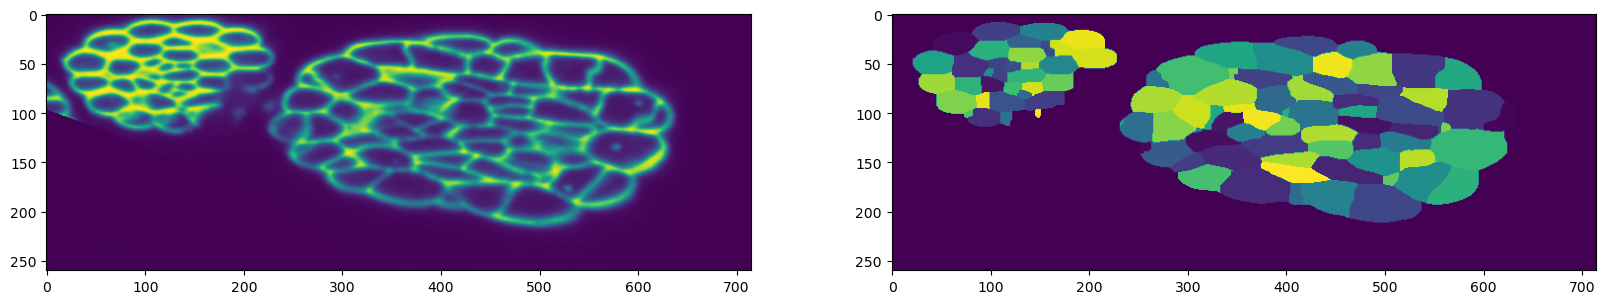

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(20, 12))
ax[0].imshow(test_h5_raw_np[:, 150])  # order: Z, Y, X -- slice along Y
ax[1].imshow(test_h5_label_np[:, 150])

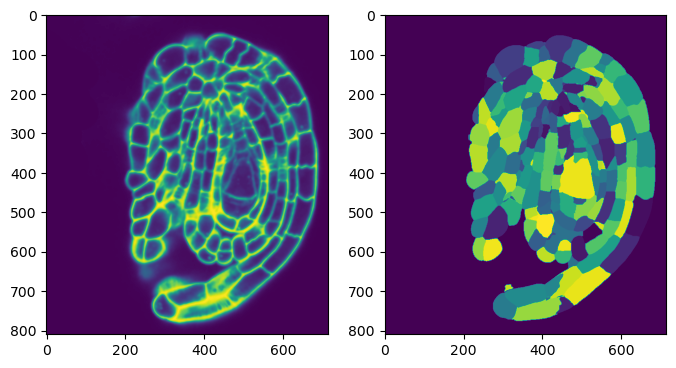

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(8, 16))
ax[0].imshow(test_h5_raw_np[150])  # order: Z, Y, X -- slice along Z
ax[1].imshow(test_h5_label_np[150])

In [117]:
np.unique(test_h5_label_np, return_counts=True)

(array([   0,    3,    4, ..., 1446, 1449, 1450], dtype=uint16),
 array([105043165,     37788,      9032, ...,     15003,     33326,
            10450]))

In [ ]:
class StandardHDF5Dataset(AbstractHDF5Dataset):
    """
    Implementation of the HDF5 dataset which loads the data from the H5 files into the memory.
    Fast but might consume a lot of memory.
    """

    def __init__(self, file_path, phase, slice_builder_config, transformer_config,
                 raw_internal_path='raw', label_internal_path='label', weight_internal_path=None,
                 global_normalization=True):
        super().__init__(file_path=file_path, phase=phase, slice_builder_config=slice_builder_config,
                         transformer_config=transformer_config, raw_internal_path=raw_internal_path,
                         label_internal_path=label_internal_path, weight_internal_path=weight_internal_path,
                         global_normalization=global_normalization)

    @staticmethod
    def create_h5_file(file_path):
        return h5py.File(file_path, 'r')

In [ ]:
# original logic that loads h5 files and makes them into pytorch Dataset objects
# from l. 125 of datasets.hdf5

def create_datasets(cls, dataset_config, phase):
    phase_config = dataset_config[phase]

    # load data augmentation configuration
    transformer_config = phase_config['transformer']
    # load slice builder config
    slice_builder_config = phase_config['slice_builder']
    # load files to process
    file_paths = phase_config['file_paths']
    # file_paths may contain both files and directories; if the file_path is a directory all H5 files inside
    # are going to be included in the final file_paths
    file_paths = cls.traverse_h5_paths(file_paths)

    datasets = []
    for file_path in file_paths:
        try:
            logger.info(f'Loading {phase} set from: {file_path}...')
            dataset = cls(file_path=file_path,
                          phase=phase,
                          slice_builder_config=slice_builder_config,
                          transformer_config=transformer_config,
                          raw_internal_path=dataset_config.get('raw_internal_path', 'raw'),
                          label_internal_path=dataset_config.get('label_internal_path', 'label'),
                          weight_internal_path=dataset_config.get('weight_internal_path', None),
                          global_normalization=dataset_config.get('global_normalization', None))
            datasets.append(dataset)
        except Exception:
            logger.error(f'Skipping {phase} set: {file_path}', exc_info=True)
    return datasets

In [23]:
# hdf5 -> torch.Tensor logic
# original definition on l. 227 of datasets.utils

def get_test_dataset(config):
    """
    Returns test Dataset.

    :return: Dataset objects
    """

    assert 'loaders' in config, 'Could not find data loaders configuration'
    loaders_config = config['loaders']

    logger.info('Creating test set loaders...')

    # get dataset class
    dataset_cls_str = loaders_config.get('dataset', None)
    if dataset_cls_str is None:
        dataset_cls_str = 'StandardHDF5Dataset'
        logger.warning(f"Cannot find dataset class in the config. Using default '{dataset_cls_str}'.")
    dataset_class = _loader_classes(dataset_cls_str)

    test_datasets = dataset_class.create_datasets(loaders_config, phase='test')
    return test_datasets
    
    
def get_test_loaders(test_datasets, config):
    """ Given a test_dataset, wrap it in a DataLoader and return
        the dataloaders.
    """
    num_workers = loaders_config.get('num_workers', 1)
    logger.info(f'Number of workers for the dataloader: {num_workers}')

    batch_size = loaders_config.get('batch_size', 1)
    if torch.cuda.device_count() > 1 and not config['device'].type == 'cpu':
        logger.info(
            f'{torch.cuda.device_count()} GPUs available. Using batch_size = {torch.cuda.device_count()} * {batch_size}')
        batch_size = batch_size * torch.cuda.device_count()

    logger.info(f'Batch size for dataloader: {batch_size}')

    # use generator in order to create data loaders lazily one by one
    for test_dataset in test_datasets:
        logger.info(f'Loading test set from: {test_dataset.file_path}...')
        if hasattr(test_dataset, 'prediction_collate'):
            collate_fn = test_dataset.prediction_collate
        else:
            collate_fn = default_prediction_collate

        yield DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
                         collate_fn=collate_fn)

In [24]:
ds_test = get_test_dataset(config)

2023-05-17 14:10:34,974 [MainThread] INFO Dataset - Creating test set loaders...
2023-05-17 14:10:34,974 [MainThread] WARNING Dataset - Cannot find dataset class in the config. Using default 'StandardHDF5Dataset'.
2023-05-17 14:10:34,975 [MainThread] INFO HDF5Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_511_final_crop_ds2.h5...
2023-05-17 14:10:35,598 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [40, 90, 90]}
2023-05-17 14:10:35,599 [MainThread] INFO HDF5Dataset - Number of patches: 432
2023-05-17 14:10:35,600 [MainThread] INFO HDF5Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_435_final_crop_ds2.h5...
2023-05-17 14:10:37,564 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [40, 90, 90]}
2023-05-17 14:10:

In [67]:
ds_test.keys()

AttributeError: 'list' object has no attribute 'keys'

In [61]:
len(ds0.raw)

260

In [62]:
ds0.raw[0].shape

(810, 715)

In [64]:
import pyplot.matplotlib as plt
plt.imshow(ds0.raw[0])

ModuleNotFoundError: No module named 'pyplot'

In [46]:
loaders = pytorch3dunet.datasets.utils.get_test_loaders(config)

In [47]:
loaders

<generator object get_test_loaders at 0x7fe789f2c660>

In [48]:
loader_example = None
for l in loaders:
    loader_example = l
    break

2023-05-17 14:37:41,115 [MainThread] INFO Dataset - Creating test set loaders...
2023-05-17 14:37:41,115 [MainThread] WARNING Dataset - Cannot find dataset class in the config. Using default 'StandardHDF5Dataset'.
2023-05-17 14:37:41,118 [MainThread] INFO HDF5Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_511_final_crop_ds2.h5...
2023-05-17 14:37:41,734 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [40, 90, 90]}
2023-05-17 14:37:41,735 [MainThread] INFO HDF5Dataset - Number of patches: 432
2023-05-17 14:37:41,736 [MainThread] INFO HDF5Dataset - Loading test set from: /scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test/N_435_final_crop_ds2.h5...
2023-05-17 14:37:43,677 [MainThread] INFO Dataset - Slice builder config: {'name': 'SliceBuilder', 'patch_shape': [80, 170, 170], 'stride_shape': [40, 90, 90]}
2023-05-17 14:37:

In [79]:
import numpy as np
e3 = np.eye(3)
e3 + 5.0

array([[6., 5., 5.],
       [5., 6., 5.],
       [5., 5., 6.]])

In [49]:
x, y = next(iter(l))

In [54]:
len(x)

1

In [50]:
x = x[0]  # but why??

In [51]:
x.shape

torch.Size([1, 80, 170, 170])

In [68]:
y[0][0]

slice(0, 80, None)

In [81]:
config['model']

{'name': 'UNet3D',
 'in_channels': 1,
 'out_channels': 1,
 'layer_order': 'gcr',
 'f_maps': 32,
 'num_groups': 8,
 'final_sigmoid': True}

In [80]:
# Create the model
model = u3.model.get_model(config['model'])
model

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(1, 1, eps=1e-05, affine=True)
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
        (SingleConv2): SingleConv(
          (groupnorm): GroupNorm(8, 16, eps=1e-05, affine=True)
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace=True)
        )
     

In [55]:
test_pred = model(x)

RuntimeError: Expected weight to be a vector of size equal to the number of channels in input, but got weight of shape [1] and input of shape [1, 80, 170, 170]

In [52]:
summary(model, x.shape, batch_size=1)

IndexError: tuple index out of range

In [31]:
test_dir = config['loaders']['test']['file_paths'][0]  # why so nested? eh, I guess I understand it...
f = h5py.File(test_dir, 'r')

# ???

IsADirectoryError: [Errno 21] Unable to open file (file read failed: time = Wed May 17 02:11:26 2023
, filename = '/scratch/groups/jyeatman/samjohns-projects/unet3d/data/osfstorage-archive-test', file descriptor = 56, errno = 21, error message = 'Is a directory', buf = 0x7ffe65145420, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)